In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error

In [2]:
df_train = pd.read_csv('/root/tempfile/train_final191219.csv')
df_test = pd.read_csv('/root/tempfile/test_final191219.csv')

In [3]:
print(df_train.shape, df_test.shape)

(201917, 106) (123623, 104)


In [4]:

feature_col = [x for x in train_df.columns if x not in ['card_id','target', 'outliers']]
y_train = train_df.target.values.astype('float')
x_train = train_df[feature_col].values.astype('float')
x_test = test_df[feature_col].values.astype('float')

testindex = test_df.card_id
del train_df, test_df


In [5]:
def regression_cv(param, data, cv):
    score = lgb.cv( 
        param, 
        data, 
        nfold=cv,
        stratified=False, 
        shuffle=True,
        metrics='rmse',
        early_stopping_rounds=50,
        verbose_eval=False, 
        show_stdv=False)
    return score['rmse-mean'][-1]


def hyperopt_train_test(params):
    global df_train
    
    param = {
        'objective':'regression',
        "boosting": "gbdt",
    }
    param['max_depth'] = int(params['max_depth'])
    param['num_leaves'] = int(params['num_leaves'])
    param['min_data_in_leaf'] = int(params['min_data_in_leaf'])
    param['reg_alpha'] = params['reg_alpha']
    param['reg_lambda'] = params['reg_lambda']
    param['feature_fraction'] = params['feature_fraction']
    
    df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'target', 'outliers']]
    data_train = lgb.Dataset(df_train[df_train_columns], label=df_train['target'])
    return regression_cv(param, data_train, cv=5)


def f(params):
    global best
    score = hyperopt_train_test(params)
    if -score > best:
        best = -score
        print('new best:', -best, params)
    return {'loss': score, 'status': STATUS_OK}

In [6]:
space4rf = {
    'max_depth': hp.quniform('max_depth', 5, 13, 1),
    'num_leaves':hp.quniform('num_leaves', 10, 350, 1),
    'min_data_in_leaf':hp.quniform('min_data_in_leaf', 10, 350, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 0.5),   
    'reg_lambda': hp.uniform('reg_lambda', 0, 0.5),
    'feature_fraction' : hp.uniform('feature_fraction', 0.5, 1)}

best = -15
trials = Trials()
best = fmin(f, space4rf, algo=tpe.suggest, max_evals=1000, trials=trials)

print('best:')
print(best)

new best: 3.6594868902423285 {'feature_fraction': 0.7605399640104678, 'max_depth': 10.0, 'min_data_in_leaf': 338.0, 'num_leaves': 261.0, 'reg_alpha': 0.403447762002815, 'reg_lambda': 0.12244910687623989}
new best: 3.658996037508916 {'feature_fraction': 0.5503257516017639, 'max_depth': 8.0, 'min_data_in_leaf': 300.0, 'num_leaves': 131.0, 'reg_alpha': 0.12082629332374684, 'reg_lambda': 0.07921996170038431}
new best: 3.658954082970829 {'feature_fraction': 0.9033794260256631, 'max_depth': 7.0, 'min_data_in_leaf': 313.0, 'num_leaves': 265.0, 'reg_alpha': 0.35132753980099646, 'reg_lambda': 0.33651085966405847}
new best: 3.6580084602033778 {'feature_fraction': 0.6229566400813662, 'max_depth': 6.0, 'min_data_in_leaf': 323.0, 'num_leaves': 115.0, 'reg_alpha': 0.44268090060991155, 'reg_lambda': 0.48822790474864886}
new best: 3.656348666880306 {'feature_fraction': 0.8408479610383566, 'max_depth': 5.0, 'min_data_in_leaf': 259.0, 'num_leaves': 45.0, 'reg_alpha': 0.4950366827340328, 'reg_lambda': 0.

In [5]:
param = {
    'learning_rate':0.001,
    'objective':'regression',
    'metric':'rmse'
}
param = dict(param, **best)
param['max_depth'] = int(param['max_depth'])
param['min_data_in_leaf'] = int(param['min_data_in_leaf'])
param['num_leaves'] = int(param['num_leaves'])

In [6]:
folds = StratifiedKFold(n_splits=10, shuffle=True)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'target', 'outliers']]


for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=df_train['target'][trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=df_train['target'][val_idx])#, categorical_feature=categorical_feats)

    num_round = 20000
    clf = lgb.train(param,
                    trn_data,
                    num_round, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval=1000,
                    early_stopping_rounds = 1000)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, df_train['target']))

fold 0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's rmse: 3.68842	valid_1's rmse: 3.72283
[2000]	training's rmse: 3.63956	valid_1's rmse: 3.69435
[3000]	training's rmse: 3.61538	valid_1's rmse: 3.68397
[4000]	training's rmse: 3.60001	valid_1's rmse: 3.67828
[5000]	training's rmse: 3.58797	valid_1's rmse: 3.67455
[6000]	training's rmse: 3.57902	valid_1's rmse: 3.6721
[7000]	training's rmse: 3.57059	valid_1's rmse: 3.6707
[8000]	training's rmse: 3.56294	valid_1's rmse: 3.66981
[9000]	training's rmse: 3.5562	valid_1's rmse: 3.66902
[10000]	training's rmse: 3.54963	valid_1's rmse: 3.66867
[11000]	training's rmse: 3.54335	valid_1's rmse: 3.66839
[12000]	training's rmse: 3.53764	valid_1's rmse: 3.66808
[13000]	training's rmse: 3.53222	valid_1's rmse: 3.66799
[14000]	training's rmse: 3.52671	valid_1's rmse: 3.66784
[15000]	training's rmse: 3.52105	valid_1's rmse: 3.66789
Early stopping, best iteration is:
[14051]	training's rmse: 3.5264	valid_1's rmse: 3.6

[9000]	training's rmse: 3.56301	valid_1's rmse: 3.62832
[10000]	training's rmse: 3.55625	valid_1's rmse: 3.62733
[11000]	training's rmse: 3.55008	valid_1's rmse: 3.62664
[12000]	training's rmse: 3.54412	valid_1's rmse: 3.62614
[13000]	training's rmse: 3.53832	valid_1's rmse: 3.62595
Early stopping, best iteration is:
[12628]	training's rmse: 3.54041	valid_1's rmse: 3.62591
fold 9
Training until validation scores don't improve for 1000 rounds.
[1000]	training's rmse: 3.6896	valid_1's rmse: 3.71182
[2000]	training's rmse: 3.64142	valid_1's rmse: 3.68371
[3000]	training's rmse: 3.61742	valid_1's rmse: 3.67346
[4000]	training's rmse: 3.60157	valid_1's rmse: 3.66944
[5000]	training's rmse: 3.5907	valid_1's rmse: 3.66625
[6000]	training's rmse: 3.5824	valid_1's rmse: 3.66399
[7000]	training's rmse: 3.57536	valid_1's rmse: 3.6626
[8000]	training's rmse: 3.56812	valid_1's rmse: 3.66193
[9000]	training's rmse: 3.56112	valid_1's rmse: 3.66133
[10000]	training's rmse: 3.55493	valid_1's rmse: 3.66

3.6504160284043414

In [11]:
folds = StratifiedKFold(n_splits=10, shuffle=True)
oof = np.zeros(x_train.shape[0])
predictions = np.zeros(x_test.shape[0])
feature_importance_df = pd.DataFrame()
outlier = np.array([1 if i<-30 else 0 for i in y_train])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train, outlier)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(x_train[trn_idx], label=y_train[trn_idx])
    val_data = lgb.Dataset(x_train[val_idx], label=y_train[val_idx])

    num_round = 30000
    clf = lgb.train(param, 
                    trn_data,
                    num_round, 
                    valid_sets = [trn_data, val_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 1000)
    
    oof[val_idx] = clf.predict(x_train[val_idx], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = feature_col
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(x_test, num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, y_train))

fold 0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's rmse: 3.69053	valid_1's rmse: 3.709
[2000]	training's rmse: 3.64098	valid_1's rmse: 3.67331
[3000]	training's rmse: 3.617	valid_1's rmse: 3.66117
[4000]	training's rmse: 3.60202	valid_1's rmse: 3.65514
[5000]	training's rmse: 3.59109	valid_1's rmse: 3.65182
[6000]	training's rmse: 3.58142	valid_1's rmse: 3.64919
[7000]	training's rmse: 3.57311	valid_1's rmse: 3.64752
[8000]	training's rmse: 3.5666	valid_1's rmse: 3.64635
[9000]	training's rmse: 3.56016	valid_1's rmse: 3.64537
[10000]	training's rmse: 3.55399	valid_1's rmse: 3.64458
[11000]	training's rmse: 3.54782	valid_1's rmse: 3.64428
[12000]	training's rmse: 3.54201	valid_1's rmse: 3.64403
[13000]	training's rmse: 3.53626	valid_1's rmse: 3.64375
[14000]	training's rmse: 3.53074	valid_1's rmse: 3.6434
[15000]	training's rmse: 3.5252	valid_1's rmse: 3.64322
[16000]	training's rmse: 3.51948	valid_1's rmse: 3.64308
[17000]	training's rmse: 3.51377	

[10000]	training's rmse: 3.55243	valid_1's rmse: 3.65295
Early stopping, best iteration is:
[9956]	training's rmse: 3.55267	valid_1's rmse: 3.65293
fold 8
Training until validation scores don't improve for 1000 rounds.
[1000]	training's rmse: 3.69088	valid_1's rmse: 3.70659
[2000]	training's rmse: 3.64153	valid_1's rmse: 3.6747
[3000]	training's rmse: 3.61715	valid_1's rmse: 3.66165
[4000]	training's rmse: 3.6019	valid_1's rmse: 3.65503
[5000]	training's rmse: 3.5906	valid_1's rmse: 3.65059
[6000]	training's rmse: 3.58155	valid_1's rmse: 3.64828
[7000]	training's rmse: 3.57372	valid_1's rmse: 3.64691
[8000]	training's rmse: 3.56668	valid_1's rmse: 3.64619
[9000]	training's rmse: 3.5602	valid_1's rmse: 3.6457
[10000]	training's rmse: 3.55395	valid_1's rmse: 3.64538
[11000]	training's rmse: 3.54776	valid_1's rmse: 3.64513
[12000]	training's rmse: 3.54172	valid_1's rmse: 3.64479
[13000]	training's rmse: 3.53577	valid_1's rmse: 3.64457
[14000]	training's rmse: 3.53034	valid_1's rmse: 3.644

3.6497440733794266

In [12]:
x_test.shape

(123623, 103)

/root/anaconda3/envs/jupyter/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


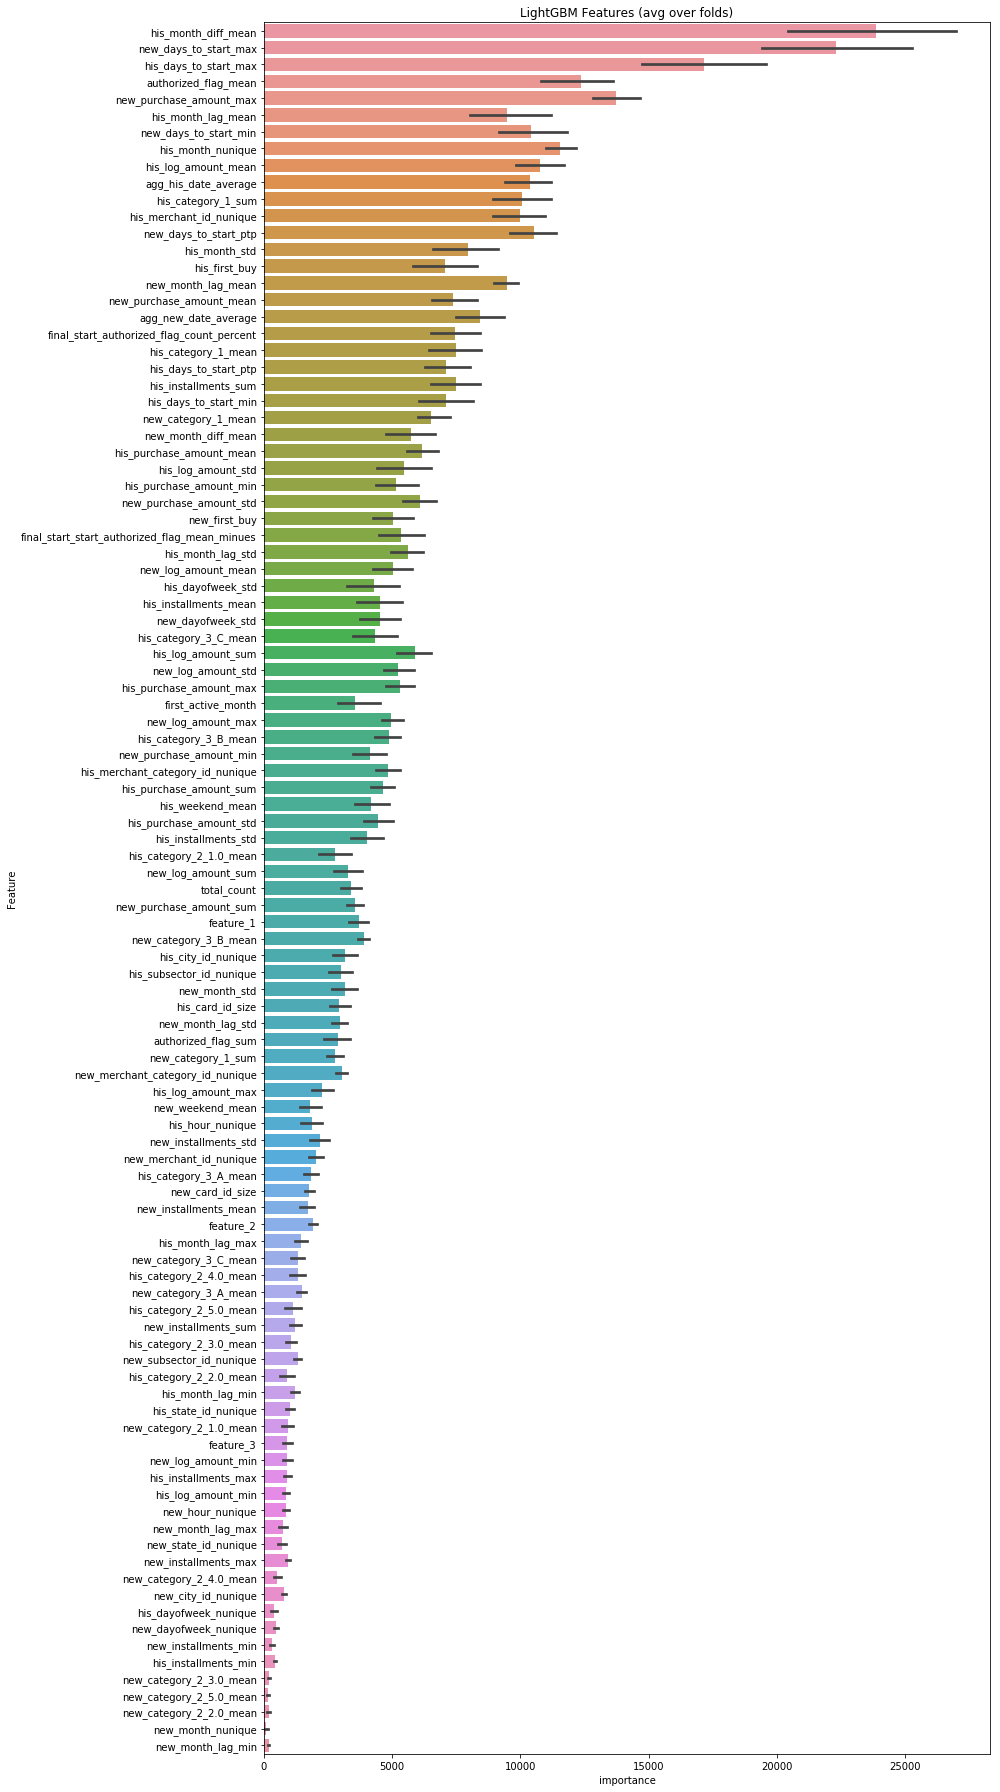

In [10]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [12]:
submission = pd.DataFrame({'card_id':df_test.card_id, 'target':predictions})
submission.to_csv('/root/tempfile/submissioncv1014.csv',index=False)

In [7]:
'''
param = {
    'feature_fraction': [0.7507665568504719],
    'max_depth': [6],
    'min_data_in_leaf': [327],
    'num_leaves': [221],
    'reg_alpha': [0.2990535105829924],
    'reg_lambda': [0.27807440463243627],
}

lgb_model1 = lgb.LGBMRegressor(objective='regression',
                              min_data_in_leaf=20,
                              num_leaves=50,
                              num_round=20000,
                              learning_rate=0.001, 
                              max_depth=8,
                              bagging_fraction = 0.8,
                              feature_fraction = 0.8,
                               num_threads=8)

gsearch11 = GridSearchCV(estimator=lgb_model1, 
                        param_grid=param,
                        scoring='neg_mean_squared_error', 
                        cv=5,
                        verbose=1, 
                        n_jobs=1)

gs11 = gsearch11.fit(x_train, y_train)
'''

"\nparam = {\n    'feature_fraction': [0.7507665568504719],\n    'max_depth': [6],\n    'min_data_in_leaf': [327],\n    'num_leaves': [221],\n    'reg_alpha': [0.2990535105829924],\n    'reg_lambda': [0.27807440463243627],\n}\n\nlgb_model1 = lgb.LGBMRegressor(objective='regression',\n                              min_data_in_leaf=20,\n                              num_leaves=50,\n                              num_round=20000,\n                              learning_rate=0.001, \n                              max_depth=8,\n                              bagging_fraction = 0.8,\n                              feature_fraction = 0.8,\n                               num_threads=8)\n\ngsearch11 = GridSearchCV(estimator=lgb_model1, \n                        param_grid=param,\n                        scoring='neg_mean_squared_error', \n                        cv=5,\n                        verbose=1, \n                        n_jobs=1)\n\ngs11 = gsearch11.fit(x_train, y_train)\n"

In [ ]:
y_test = gs11.predict(x_test)

In [ ]:
submission = pd.DataFrame({'card_id':testindex, 'target':predictions})
submission.to_csv('/root/tempfile/submission19121633.csv',index=False)